## Importing Packages

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import zipfile

import tensorflow as tf

from google.colab import drive

In [0]:
#import tensorflow_hub as hub

In [0]:
import math

## Setting session of keras and Tensorflow backend to be same for model export in future

In [0]:
tf.keras.backend.set_session = tf.Session()

## Mounting Google Drive to load data

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/

/content/drive


In [0]:
cd 'My Drive'

/content/drive/My Drive


## Extracting data to temp folder for fast access

In [0]:
local_zip = 'cash_full_data/full_data.zip' # local path of downloaded .zip file
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp') # contents are extracted to '/tmp' folder
zip_ref.close()

In [0]:
!cd /tmp && cd full_data/ && ls

train  valid


## Setting up train and validation directory

In [0]:
base_dir = '/tmp/full_data'
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'valid')

## Setting up Batch size, number of epochs, and input image shape for the model

In [0]:
batch_size = 100
epochs = 100
IMG_SHAPE = 224 # Our training data will consists of images with width of 150 pixels and height of 150 pixels

## Loading Pre-trained model

In [0]:
pre_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.0, depth_multiplier=1, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


## Setting all the layers of pre-trained model to be false trainable

In [0]:
for layer in pre_model.layers:
    layer.trainable = False

## Setting up image data pipeline 

In [0]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5
                    )

# train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [0]:
train_data_gen = train_image_generator.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                class_mode='categorical',
                                                target_size=(IMG_SHAPE,IMG_SHAPE))

Found 11981 images belonging to 7 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=50, 
                                                              directory=validation_dir, 
                                                              class_mode='categorical',
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),shuffle=False) #(224,224)

Found 3334 images belonging to 7 classes.


In [0]:
num_of_test_samples = 3334

## Examining the data

In [0]:
sample_training_images, _ = next(train_data_gen) 

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

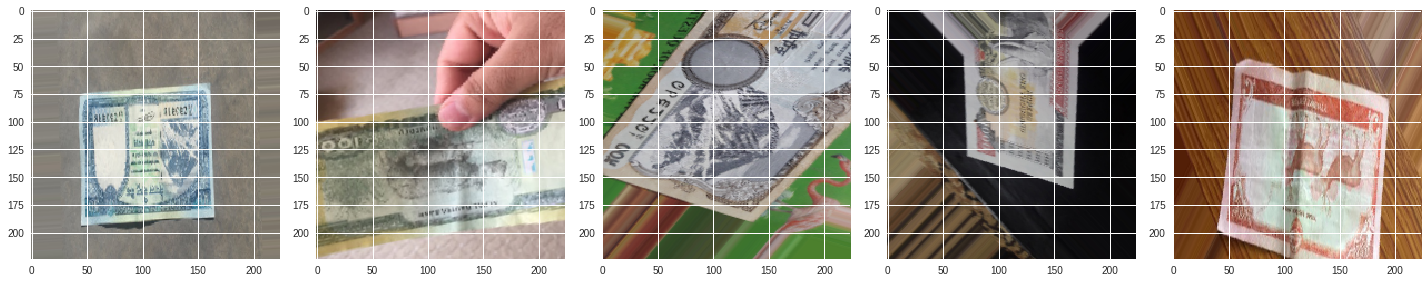

In [0]:
plotImages(sample_training_images[:5])

## Setting up the model (Transfer Learning)

In [0]:
model_fine = tf.keras.models.Sequential()

In [0]:
model_fine.add(pre_model)

In [0]:
model_fine.add(tf.keras.layers.Flatten())

In [0]:
model_fine.add(tf.keras.layers.Dense(64, activation='relu'))
model_fine.add(tf.keras.layers.Dropout(0.4))
model_fine.add(tf.keras.layers.Dense(32, activation='relu'))

In [0]:
model_fine.add(tf.keras.layers.Dense(7, activation='softmax'))

In [0]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 231       
Total params: 6,274,439
Trainable params: 4,016,455
Non-trainable params: 2,257,984
__________________________________________________________

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

## Training the model

In [0]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 64s 3s/step - loss: 1.7842 - categorical_accuracy: 0.3170 - val_loss: 1.0427 - val_categorical_accuracy: 0.8880
Epoch 2/50
20/20 [==============================] - 50s 2s/step - loss: 1.1775 - categorical_accuracy: 0.5620 - val_loss: 0.3769 - val_categorical_accuracy: 0.9560
Epoch 3/50
20/20 [==============================] - 49s 2s/step - loss: 0.8235 - categorical_accuracy: 0.7218 - val_loss: 0.2129 - val_categorical_accuracy: 0.9800
Epoch 4/50
20/20 [==============================] - 49s 2s/step - loss: 0.6736 - categorical_accuracy: 0.7580 - val_loss: 0.2133 - val_categorical_accuracy: 0.9660
Epoch 5/50
20/20 [==============================] - 50s 3s/step - loss: 0.5997 - categorical_accuracy: 0.7860 - val_loss: 0.1781 - val_categorical_accuracy: 0.9690
Epoch 6/50
20/20 [==============================] - 50s 3s/step - loss: 0.5331 - categorical_accuracy: 0.8210 - val_loss: 0.1540 - val_categorical_accuracy: 0.9710
Epoch 7/50
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

[1.3812909626662393, 0.6568686259864652]

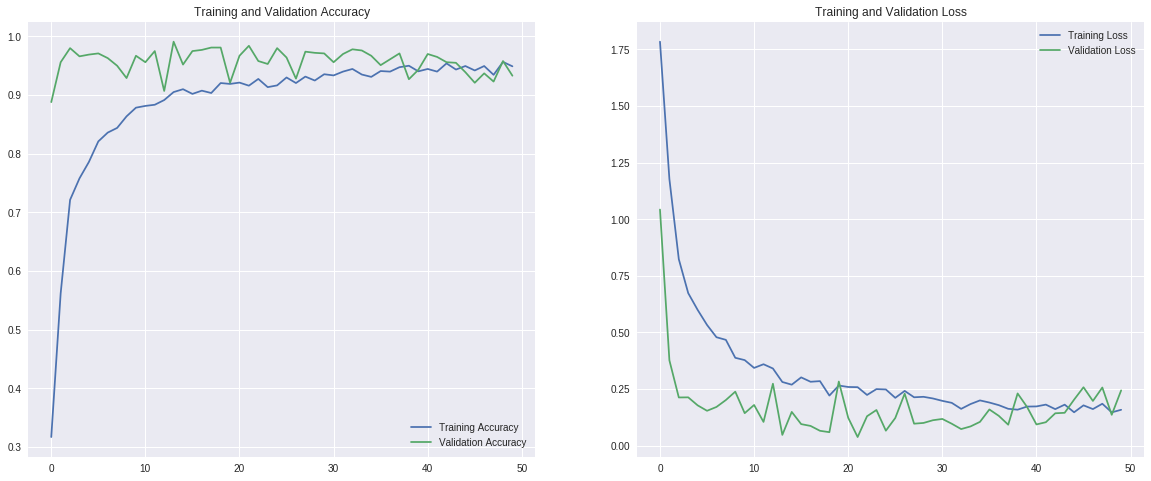

In [0]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model_fine.save("CashKeras-50-transfer-epoch-drpt-03-lr0001.h5")

In [0]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
position_layer = pre_model.get_layer('block_15_add')

In [0]:
  # Fine Tuning
  for layer in pre_model.layers:
  layer.trainable = True

In [0]:
all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 231       
Total params: 6,274,439
Trainable params: 4,902,535
Non-trainable params: 1,371,904
__________________________________________________________

In [0]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 65s 3s/step - loss: 0.1731 - categorical_accuracy: 0.9445 - val_loss: 0.3575 - val_categorical_accuracy: 0.9000
Epoch 2/50
20/20 [==============================] - 50s 3s/step - loss: 0.1548 - categorical_accuracy: 0.9525 - val_loss: 0.4939 - val_categorical_accuracy: 0.8690
Epoch 3/50
20/20 [==============================] - 50s 3s/step - loss: 0.1645 - categorical_accuracy: 0.9534 - val_loss: 0.4509 - val_categorical_accuracy: 0.8850
Epoch 4/50
20/20 [==============================] - 50s 3s/step - loss: 0.1524 - categorical_accuracy: 0.9535 - val_loss: 0.1021 - val_categorical_accuracy: 0.9700
Epoch 5/50
20/20 [==============================] - 50s 3s/step - loss: 0.1623 - categorical_accuracy: 0.9500 - val_loss: 0.2300 - val_categorical_accuracy: 0.9220
Epoch 6/50
20/20 [==============================] - 50s 2s/step - loss: 0.1248 - categorical_accuracy: 0.9590 - val_loss: 0.2179 - val_categorical_accuracy: 0.9340
Epoch 7/50
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

[1.9052399594705436, 0.7126574669285813]

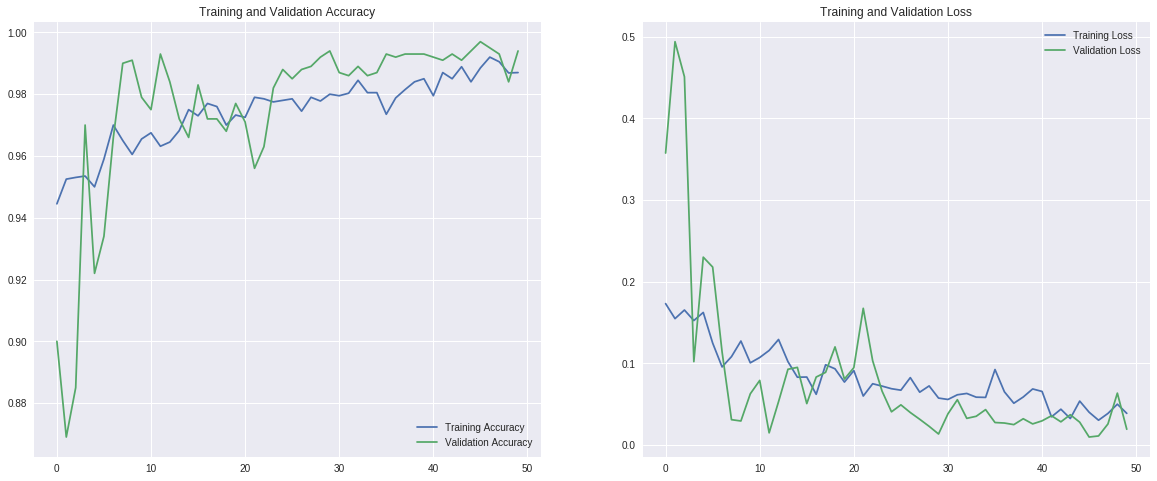

In [0]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model_fine.save("CashKeras-50-finetune-epoch-drpt-03-lr0001.h5")

In [0]:
#tf.keras.models.save_model(model_fine, "Models/keras200lr0001.h5", include_optimizer=True)

In [0]:
!pwd

/content/drive/My Drive


In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
Y_pred = model_fine.predict_generator(val_data_gen)

In [0]:
y_pred = np.argmax(Y_pred, axis=1)

In [0]:
y_pred.shape

(3334,)

In [0]:
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))

Confusion Matrix
[[509   1   3   0   2   0   0]
 [  0 501   0   0   0   0   0]
 [ 76  47 323   3  18  32   2]
 [244   5   4 220  12   8  28]
 [116 102  10   1 196   3  17]
 [ 87  25  10   0   2 377   0]
 [ 16  84   0   0   0   0 250]]


In [0]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [0]:
val_data_gen.class_indices

{'fifty': 0,
 'five': 1,
 'fivehundred': 2,
 'hundred': 3,
 'ten': 4,
 'thousand': 5,
 'twenty': 6}

In [0]:
print('Classification Report')
target_names = ['fifty', 'five', 'fivehundred', 'hundred', 'ten', 'thousand', 'twenty']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fifty       0.49      0.99      0.65       515
        five       0.65      1.00      0.79       501
 fivehundred       0.92      0.64      0.76       501
     hundred       0.98      0.42      0.59       521
         ten       0.85      0.44      0.58       445
    thousand       0.90      0.75      0.82       501
      twenty       0.84      0.71      0.77       350

   micro avg       0.71      0.71      0.71      3334
   macro avg       0.81      0.71      0.71      3334
weighted avg       0.80      0.71      0.71      3334



In [0]:
import itertools

from sklearn.metrics import confusion_matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[509   1   3   0   2   0   0]
 [  0 501   0   0   0   0   0]
 [ 76  47 323   3  18  32   2]
 [244   5   4 220  12   8  28]
 [116 102  10   1 196   3  17]
 [ 87  25  10   0   2 377   0]
 [ 16  84   0   0   0   0 250]]
Normalized confusion matrix
[[0.99 0.   0.01 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.15 0.09 0.64 0.01 0.04 0.06 0.  ]
 [0.47 0.01 0.01 0.42 0.02 0.02 0.05]
 [0.26 0.23 0.02 0.   0.44 0.01 0.04]
 [0.17 0.05 0.02 0.   0.   0.75 0.  ]
 [0.05 0.24 0.   0.   0.   0.   0.71]]


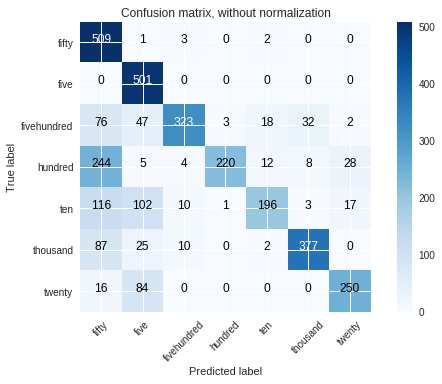

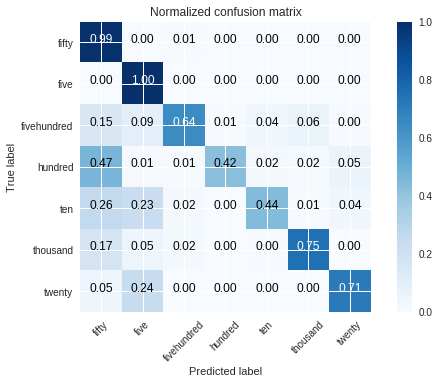

In [0]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
cm

array([[416,  18,  24,  10,  22,  11,  14],
       [  0, 501,   0,   0,   0,   0,   0],
       [  8,  70, 335,   2,   7,  75,   4],
       [ 55,  31,   6, 243,  50,  86,  50],
       [ 59, 157,  38,   1, 161,  10,  19],
       [  7,  26,  27,   0,  12, 429,   0],
       [  7, 107,   0,   3,   4,   1, 228]])

In [0]:
output_path = tf.contrib.saved_model.save_keras_model(model_fine, 'KerasCashFineTuned50/')

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

In [0]:
#!tflite_convert --output_file=Cash.tflite --saved_model_dir=savedModel_cash100/1546849938

In [0]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
position_layer = pre_model.get_layer('block_13_expand')

In [0]:
for layer in pre_model.layers:
  layer.trainable = True

In [0]:
all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 231       
Total params: 6,274,439
Trainable params: 5,697,799
Non-trainable params: 576,640
____________________________________________________________

In [0]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 66s 3s/step - loss: 0.0414 - categorical_accuracy: 0.9870 - val_loss: 0.0195 - val_categorical_accuracy: 0.9950
Epoch 2/50
20/20 [==============================] - 50s 3s/step - loss: 0.0515 - categorical_accuracy: 0.9845 - val_loss: 0.0196 - val_categorical_accuracy: 0.9950
Epoch 3/50
20/20 [==============================] - 51s 3s/step - loss: 0.0349 - categorical_accuracy: 0.9845 - val_loss: 0.0197 - val_categorical_accuracy: 0.9950
Epoch 4/50
20/20 [==============================] - 51s 3s/step - loss: 0.0376 - categorical_accuracy: 0.9905 - val_loss: 0.0198 - val_categorical_accuracy: 0.9950
Epoch 5/50
20/20 [==============================] - 50s 3s/step - loss: 0.0448 - categorical_accuracy: 0.9855 - val_loss: 0.0203 - val_categorical_accuracy: 0.9950
Epoch 6/50
20/20 [==============================] - 50s 2s/step - loss: 0.0619 - categorical_accuracy: 0.9819 - val_loss: 0.0207 - val_categorical_accuracy: 0.9950
Epoch 7/50
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

[1.1621633192247076, 0.787642472676696]

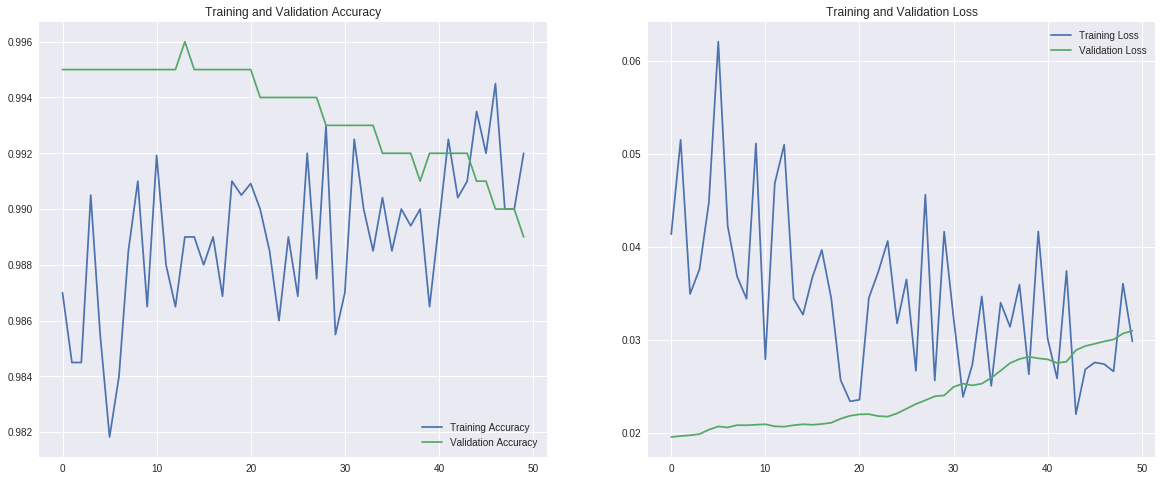

In [0]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model_fine.save("CashKeras-50-finetune_2-epoch-drpt-03-lr0001.h5")

In [0]:
output_path = tf.contrib.saved_model.save_keras_model(model_fine, 'KerasCashFineTuned50_2/')

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

In [0]:
Y_pred = model_fine.predict_generator(val_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))



Confusion Matrix
[[504   2   3   1   3   1   1]
 [  1 500   0   0   0   0   0]
 [ 28  50 305  11  20  87   0]
 [ 99   3   1 348   5  40  25]
 [ 98  82  10   2 211  21  21]
 [ 12   5   2   0   0 482   0]
 [ 11  61   0   0   2   0 276]]


In [0]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [0]:
print('Classification Report')
target_names = ['fifty', 'five', 'fivehundred', 'hundred', 'ten', 'thousand', 'twenty']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fifty       0.67      0.98      0.79       515
        five       0.71      1.00      0.83       501
 fivehundred       0.95      0.61      0.74       501
     hundred       0.96      0.67      0.79       521
         ten       0.88      0.47      0.62       445
    thousand       0.76      0.96      0.85       501
      twenty       0.85      0.79      0.82       350

   micro avg       0.79      0.79      0.79      3334
   macro avg       0.83      0.78      0.78      3334
weighted avg       0.82      0.79      0.78      3334



Confusion matrix, without normalization
[[504   2   3   1   3   1   1]
 [  1 500   0   0   0   0   0]
 [ 28  50 305  11  20  87   0]
 [ 99   3   1 348   5  40  25]
 [ 98  82  10   2 211  21  21]
 [ 12   5   2   0   0 482   0]
 [ 11  61   0   0   2   0 276]]
Normalized confusion matrix
[[0.98 0.   0.01 0.   0.01 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.06 0.1  0.61 0.02 0.04 0.17 0.  ]
 [0.19 0.01 0.   0.67 0.01 0.08 0.05]
 [0.22 0.18 0.02 0.   0.47 0.05 0.05]
 [0.02 0.01 0.   0.   0.   0.96 0.  ]
 [0.03 0.17 0.   0.   0.01 0.   0.79]]


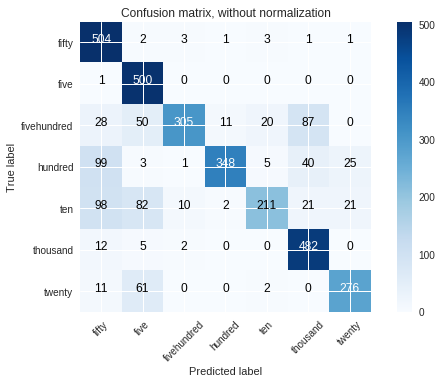

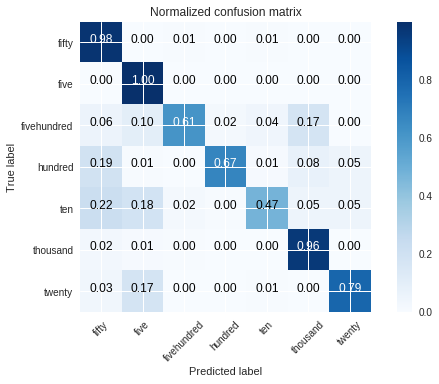

In [0]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
output_path

b'KerasCashFineTuned50_2/1547020680'

In [0]:
!tflite_convert --output_file=Cash.tflite --saved_model_dir=KerasCashFineTuned50_2/1547020680

2019-01-09 08:05:21.160786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-01-09 08:05:21.161264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 6.92GiB
2019-01-09 08:05:21.161310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-01-09 08:05:22.139846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-01-09 08:05:22.139911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-01-09 08:05:22.139926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-01-09 08:05:22.140129: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:

In [0]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [0]:
position_layer = pre_model.get_layer('block_8_expand')

for layer in pre_model.layers:
  layer.trainable = True
  
all_layers = pre_model.layers
for i in range(pre_model.layers.index(position_layer)):
    all_layers[i].trainable = False

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0000001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 231       
Total params: 6,274,439
Trainable params: 6,109,511
Non-trainable params: 164,928
____________________________________________________________

In [0]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=20, steps_per_epoch=20, validation_steps=20)

Epoch 1/20
20/20 [==============================] - 67s 3s/step - loss: 0.0209 - categorical_accuracy: 0.9920 - val_loss: 0.0309 - val_categorical_accuracy: 0.9880
Epoch 2/20
20/20 [==============================] - 51s 3s/step - loss: 0.0212 - categorical_accuracy: 0.9935 - val_loss: 0.0310 - val_categorical_accuracy: 0.9870
Epoch 3/20
20/20 [==============================] - 51s 3s/step - loss: 0.0328 - categorical_accuracy: 0.9897 - val_loss: 0.0311 - val_categorical_accuracy: 0.9870
Epoch 4/20
20/20 [==============================] - 51s 3s/step - loss: 0.0331 - categorical_accuracy: 0.9915 - val_loss: 0.0312 - val_categorical_accuracy: 0.9870
Epoch 5/20
20/20 [==============================] - 51s 3s/step - loss: 0.0288 - categorical_accuracy: 0.9925 - val_loss: 0.0314 - val_categorical_accuracy: 0.9860
Epoch 6/20
20/20 [==============================] - 51s 3s/step - loss: 0.0418 - categorical_accuracy: 0.9860 - val_loss: 0.0316 - val_categorical_accuracy: 0.9860
Epoch 7/20
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

[1.04023853559502, 0.8014397104172987]

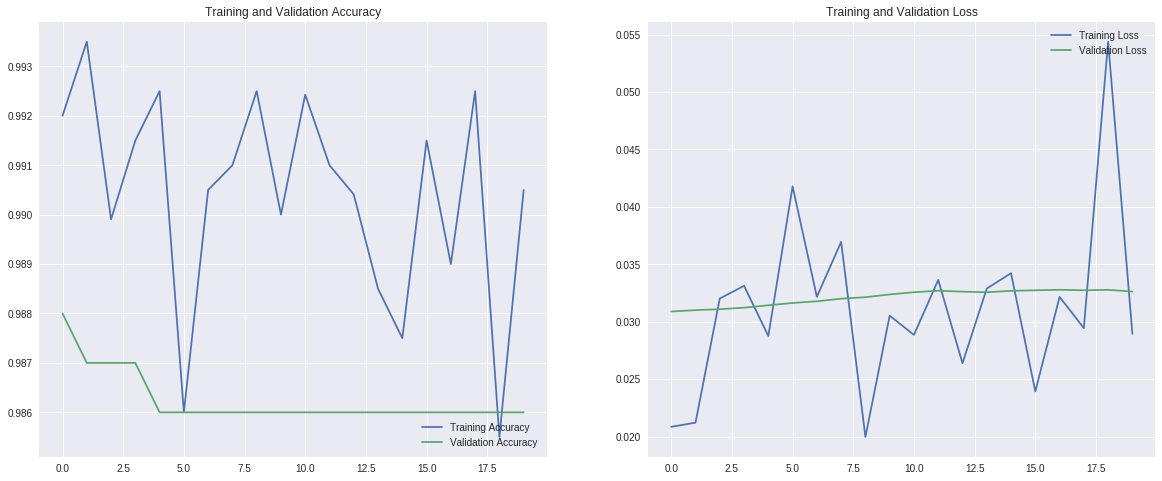

In [0]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model_fine.save("CashKeras-50-finetune_3-epoch-drpt-03-lr0001.h5")

In [0]:
output_path = tf.contrib.saved_model.save_keras_model(model_fine, 'KerasCashFineTuned50_3/')

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

In [0]:
Y_pred = model_fine.predict_generator(val_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))



Confusion Matrix
[[501   2   3   1   5   2   1]
 [  0 501   0   0   0   0   0]
 [ 26  52 283   8  17 115   0]
 [ 65   2   0 376   4  54  20]
 [ 86  66   8   4 227  26  28]
 [  8   4   0   0   0 489   0]
 [  8  44   0   0   2   1 295]]


In [0]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [0]:
print('Classification Report')
target_names = ['fifty', 'five', 'fivehundred', 'hundred', 'ten', 'thousand', 'twenty']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fifty       0.72      0.97      0.83       515
        five       0.75      1.00      0.85       501
 fivehundred       0.96      0.56      0.71       501
     hundred       0.97      0.72      0.83       521
         ten       0.89      0.51      0.65       445
    thousand       0.71      0.98      0.82       501
      twenty       0.86      0.84      0.85       350

   micro avg       0.80      0.80      0.80      3334
   macro avg       0.84      0.80      0.79      3334
weighted avg       0.84      0.80      0.79      3334



Confusion matrix, without normalization
[[501   2   3   1   5   2   1]
 [  0 501   0   0   0   0   0]
 [ 26  52 283   8  17 115   0]
 [ 65   2   0 376   4  54  20]
 [ 86  66   8   4 227  26  28]
 [  8   4   0   0   0 489   0]
 [  8  44   0   0   2   1 295]]
Normalized confusion matrix
[[0.97 0.   0.01 0.   0.01 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.05 0.1  0.56 0.02 0.03 0.23 0.  ]
 [0.12 0.   0.   0.72 0.01 0.1  0.04]
 [0.19 0.15 0.02 0.01 0.51 0.06 0.06]
 [0.02 0.01 0.   0.   0.   0.98 0.  ]
 [0.02 0.13 0.   0.   0.01 0.   0.84]]


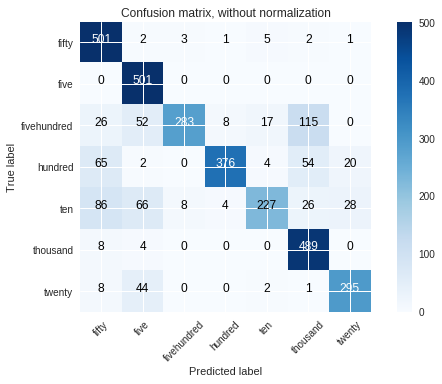

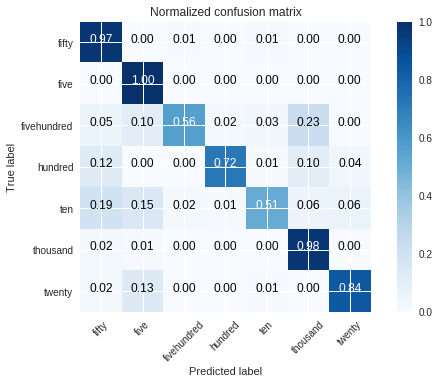

In [0]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
for layer in pre_model.layers:
  layer.trainable = True

In [0]:
model_fine.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0000001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_fine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 231       
Total params: 6,274,439
Trainable params: 6,240,327
Non-trainable params: 34,112
_____________________________________________________________

In [0]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=50, steps_per_epoch=20, validation_steps=20)

Epoch 1/50
20/20 [==============================] - 75s 4s/step - loss: 0.0246 - categorical_accuracy: 0.9895 - val_loss: 0.0311 - val_categorical_accuracy: 0.9850
Epoch 2/50
20/20 [==============================] - 57s 3s/step - loss: 0.0320 - categorical_accuracy: 0.9870 - val_loss: 0.0298 - val_categorical_accuracy: 0.9870
Epoch 3/50
20/20 [==============================] - 58s 3s/step - loss: 0.0372 - categorical_accuracy: 0.9900 - val_loss: 0.0287 - val_categorical_accuracy: 0.9870
Epoch 4/50
20/20 [==============================] - 58s 3s/step - loss: 0.0328 - categorical_accuracy: 0.9895 - val_loss: 0.0277 - val_categorical_accuracy: 0.9870
Epoch 5/50
20/20 [==============================] - 57s 3s/step - loss: 0.0456 - categorical_accuracy: 0.9874 - val_loss: 0.0266 - val_categorical_accuracy: 0.9890
Epoch 6/50
20/20 [==============================] - 56s 3s/step - loss: 0.0393 - categorical_accuracy: 0.9880 - val_loss: 0.0258 - val_categorical_accuracy: 0.9900
Epoch 7/50
20/20

In [0]:
model_fine.evaluate_generator(val_data_gen)

[0.3818444494975334, 0.9196160777858009]

In [0]:
model_fine.save("CashKeras-50-finetune_all-epoch-drpt-03-lr0000001.h5")

In [0]:
output_path = tf.contrib.saved_model.save_keras_model(model_fine, 'KerasCashFineTuned50_all/')

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

In [0]:
Y_pred = model_fine.predict_generator(val_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))



Confusion Matrix
[[511   0   1   3   0   0   0]
 [  0 501   0   0   0   0   0]
 [  0   9 465   0   0  27   0]
 [ 47   0   1 421   4  42   6]
 [ 46   6  19   6 336  25   7]
 [  1   1   1   0   0 497   1]
 [  3   6   0   3   2   1 335]]


In [0]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [0]:
print('Classification Report')
target_names = ['fifty', 'five', 'fivehundred', 'hundred', 'ten', 'thousand', 'twenty']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       fifty       0.84      0.99      0.91       515
        five       0.96      1.00      0.98       501
 fivehundred       0.95      0.93      0.94       501
     hundred       0.97      0.81      0.88       521
         ten       0.98      0.76      0.85       445
    thousand       0.84      0.99      0.91       501
      twenty       0.96      0.96      0.96       350

   micro avg       0.92      0.92      0.92      3334
   macro avg       0.93      0.92      0.92      3334
weighted avg       0.93      0.92      0.92      3334



Confusion matrix, without normalization
[[511   0   1   3   0   0   0]
 [  0 501   0   0   0   0   0]
 [  0   9 465   0   0  27   0]
 [ 47   0   1 421   4  42   6]
 [ 46   6  19   6 336  25   7]
 [  1   1   1   0   0 497   1]
 [  3   6   0   3   2   1 335]]
Normalized confusion matrix
[[0.99 0.   0.   0.01 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.93 0.   0.   0.05 0.  ]
 [0.09 0.   0.   0.81 0.01 0.08 0.01]
 [0.1  0.01 0.04 0.01 0.76 0.06 0.02]
 [0.   0.   0.   0.   0.   0.99 0.  ]
 [0.01 0.02 0.   0.01 0.01 0.   0.96]]


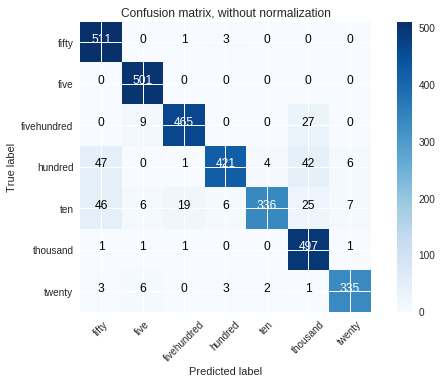

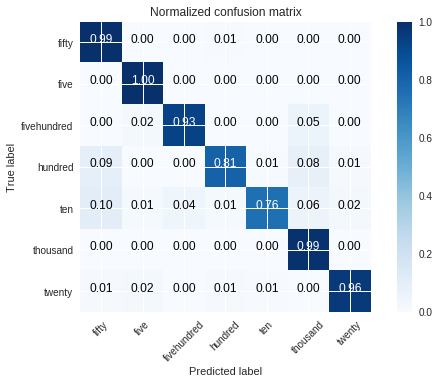

In [0]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
output_path

b'KerasCashFineTuned50_all/1547027314'

In [0]:
!tflite_convert --output_file=Cash.tflite --saved_model_dir=KerasCashFineTuned50_all/1547027314

2019-01-09 09:52:26.990536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-01-09 09:52:26.990869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 418.19MiB
2019-01-09 09:52:26.990910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-01-09 09:52:27.444126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-01-09 09:52:27.444204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-01-09 09:52:27.444237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-01-09 09:52:27.444377: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.c

In [0]:
val_data_gen.class_indices

{'fifty': 0,
 'five': 1,
 'fivehundred': 2,
 'hundred': 3,
 'ten': 4,
 'thousand': 5,
 'twenty': 6}

In [0]:
train_data_gen.class_indices

{'fifty': 0,
 'five': 1,
 'fivehundred': 2,
 'hundred': 3,
 'ten': 4,
 'thousand': 5,
 'twenty': 6}